In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import sys
sys.path.append("../../")
from data.datasets import WeatherBenchModule
from models import LightningDRN, EmbeddingMLP, LightningDER
import xarray as xr
import cmcrameri
from uq import GaussianUQMeasure
plt.rcParams['image.cmap'] = 'cmc.vik'
from matplotlib.colors import LogNorm
import scienceplots
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cmp


# Disable gradients
torch.set_grad_enabled(False)

In [2]:
grid = (160,220)
statistics = np.load("/home/groups/ai/datasets/weather_forecasting/era5_statistics.npy")
mean, std = statistics[0]
dm = WeatherBenchModule(train_batch_size=8192, num_workers = 12)
lon, lat = dm.test_dataloader().dataset.get_grid()

In [3]:
land_sea_mask = xr.open_zarr("/home/groups/ai/datasets/weather_forecasting/era5.zarr", consolidated=False).land_sea_mask.values
mask = np.where(land_sea_mask > 0.5, 1, 0)
orography = xr.open_zarr("/home/groups/ai/datasets/weather_forecasting/era5.zarr", consolidated=False)["geopotential_at_surface"].values / 9.80665

# Ensemble

## Analyze uncertainties

In [4]:
mlp = EmbeddingMLP()
model = LightningDRN(mlp)
sample = dm.test_dataloader().dataset.__getitem__(10)
input, emb, target = sample

batch_size = 365

target = target.squeeze().reshape(grid).numpy()* std + mean- 273.15
input = input[...,0].squeeze().reshape(grid).numpy()*std + mean- 273.15
len(dm.test_dataloader().dataset)

365

In [ ]:
checkpoints = [1,2,3,4,5,6,7,8,9,10]
results = np.zeros((batch_size, 160,220, 2, len(checkpoints)))
for i,c in enumerate(checkpoints):
    ck_path = f"../../results/drn/ensemble/checkpoints/mlp_{c}.ckpt"
    checkpoint = torch.load(ck_path)
    model.load_state_dict(checkpoint["state_dict"])

    for s,sample in enumerate(dm.test_dataloader()):
        input, emb, target = sample    
        pred = model.predict_step(sample).reshape(160,220,2)
        pred[...,0] = pred[...,0]*std + mean - 273.15
        pred[...,1] = pred[...,1]*std  
        
        results[s,...,i] = pred

/tmp/ipykernel_123855/4253467555.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ck_path)


In [6]:
measures = ["log", "var", "crps", "kernel"]
names = [r"$S_\mathrm{log}$",r"$S_\mathrm{SE}$",r"$S_\mathrm{ES}$",r"$S_{k_\gamma}$"]

In [7]:
plt.style.use('science')
titlesize = 34
labelsize = 26
ticksize = 24
axissize = 29

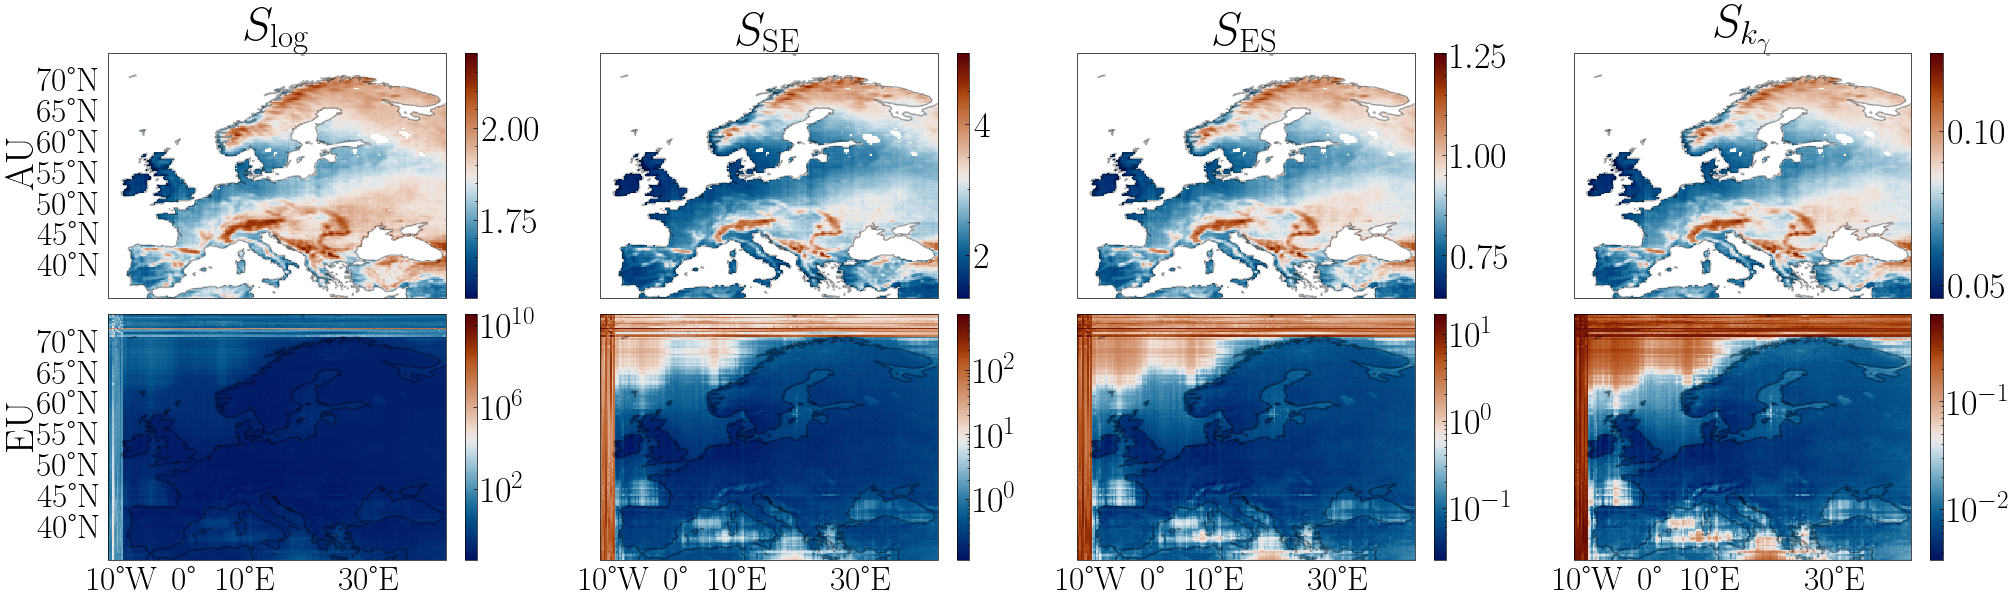

In [8]:
fig, axs = plt.subplots(2, len(measures), figsize=(20, 6), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, layout = "constrained")
for s,measure in enumerate(measures):
    uq_measure = GaussianUQMeasure(torch.tensor(results), gamma = 5)
    au, eu, _ = uq_measure.get_uncertainties(measure = measure)
    au = au.mean(dim = 0)
    eu = eu.mean(dim = 0)
    au = np.where(land_sea_mask <= 0.5, np.nan, au)

    # Plot
    im1 = axs[0,s].pcolormesh(lon, lat, au, shading = "nearest", rasterized = True)
    cb = plt.colorbar(im1, ax=axs[0,s])
    cb.ax.tick_params(labelsize = labelsize)

    im2 = axs[1,s].pcolormesh(lon, lat, eu,rasterized = True, norm = LogNorm())
    cb2 = plt.colorbar(im2, ax=axs[1,s])
    cb2.ax.tick_params(labelsize = labelsize)

    axs[0,s].set_title(names[s], fontsize = titlesize)

for ax in axs.ravel():
    ax.set_extent([lon[0]-360, lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, alpha = 0.35)

for i in range(4):
    gl = axs[1,i].gridlines(draw_labels={"bottom":"x"}, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size':ticksize}

for i in range(2):
    gl = axs[i,0].gridlines(draw_labels={"left":"y"}, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.ylabel_style = {'size':ticksize}

axs[0,0].text(-0.2, 0.55, 'AU', va='bottom', ha='center',
              rotation='vertical', rotation_mode='anchor',
              transform=axs[0,0].transAxes, fontsize = axissize)
axs[1,0].text(-0.2, 0.55, 'EU', va='bottom', ha='center',
     rotation='vertical', rotation_mode='anchor',
    transform=axs[1,0].transAxes, fontsize = axissize)

plt.savefig("../../plots/drn_uncertainty.pdf", bbox_inches = "tight")

## Data Characteristics

In [9]:
from matplotlib.colors import ListedColormap, CenteredNorm, PowerNorm

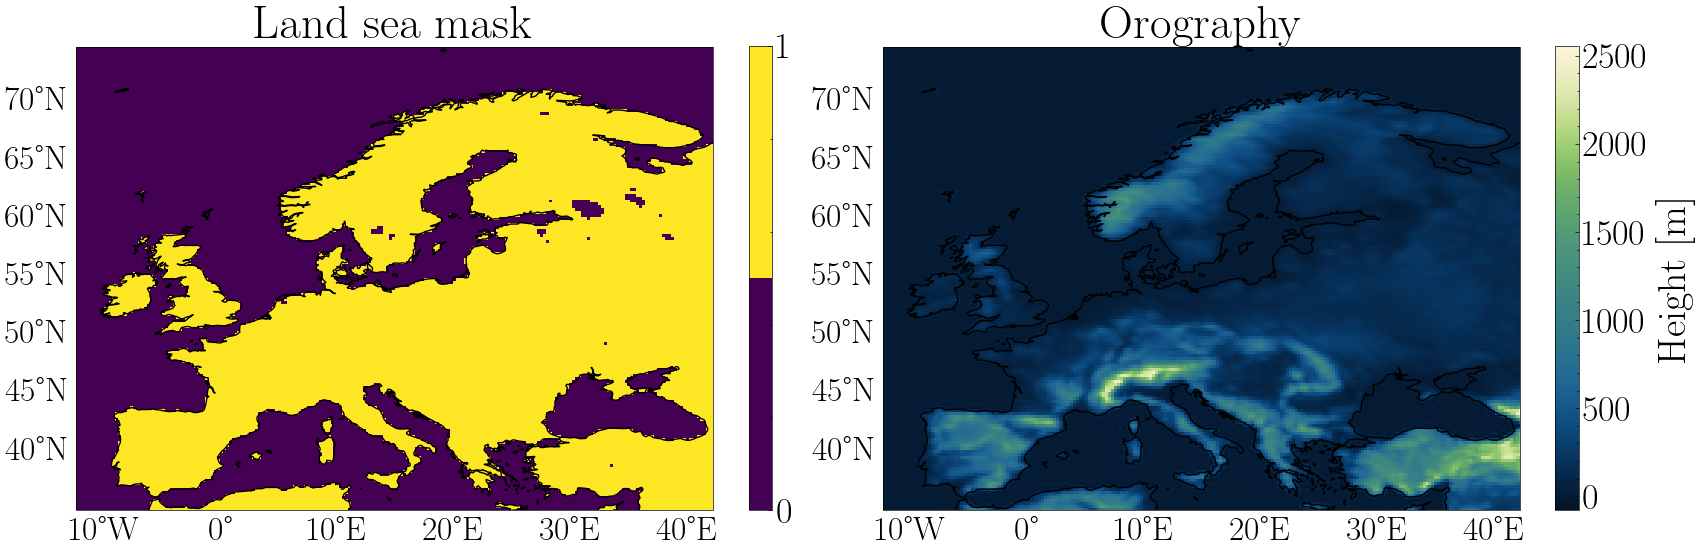

In [10]:
# Discrete colorbar
viridis = cmp.get_cmap('viridis')    
col_dict = {0: viridis(0),
            1: viridis(0.999)}

# We create a colormar from our list of colors
cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

fig, axs = plt.subplots(1, 2, figsize=(17, 6), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, layout = "constrained")
im1 = axs[0].pcolormesh(lon, lat, mask, shading = "nearest", cmap = cmap_coverage, rasterized = True)
cb = plt.colorbar(im1, ax=axs[0], label = "", ticks = np.array([0,1]), shrink = 0.785)
cb.ax.tick_params(labelsize = labelsize)
axs[0].set_title("Land sea mask", size = titlesize)


im2 = axs[1].pcolormesh(lon , lat, orography, shading = "nearest", cmap = "cmc.navia", rasterized = True)
cb2 = plt.colorbar(im2, ax=axs[1], shrink = 0.785)
cb2.set_label('Height [m]',size=axissize)
cb2.ax.tick_params(labelsize = labelsize)
axs[1].set_title("Orography", size = titlesize)

for ax in axs.ravel():
    ax.set_extent([lon[0]-360, lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(draw_labels={"bottom":"x", "left":"y"}, dms=True, x_inline=False, y_inline=False)
    gl.ylabel_style = {'size':ticksize}
    gl.xlabel_style = {"size":ticksize}
    gl.xlines = False
    gl.ylines = False

plt.savefig("../../plots/drn_data.pdf", bbox_inches = "tight")

# DER

In [8]:
from torch.distributions.inverse_gamma import InverseGamma
from torch.distributions.normal import Normal

In [9]:
mlp = EmbeddingMLP(n_outputs = 4)
sample = dm.test_dataloader().dataset.__getitem__(10)
input, emb, target = sample

batch_size = 365

target = target.squeeze().reshape(grid).numpy()* std + mean- 273.15
input = input[...,0].squeeze().reshape(grid).numpy()*std + mean- 273.15
len(dm.test_dataloader().dataset)

365

In [51]:
coeff = 0.0
m = 10

results = np.zeros((batch_size, 160,220, 2, m))
model = LightningDER(mlp, coeff = coeff)
ck_path = f"../../results/drn/der/checkpoints/mlp_{coeff}.ckpt"
checkpoint = torch.load(ck_path)
model.load_state_dict(checkpoint["state_dict"])

for s,sample in enumerate(dm.test_dataloader()):
    input, emb, target = sample    
    pred = model.predict_step(sample).reshape(160,220,4)
    gamma, nu, alpha, beta = torch.split(pred, 1 , dim = -1)

    gamma = gamma.squeeze().repeat((m,1,1))
    nu = nu.squeeze().repeat((m,1,1))
    invg = InverseGamma(alpha.squeeze(), beta.squeeze())
    sigma2 = invg.sample((m,))
    norm = Normal(gamma, torch.sqrt(sigma2/(nu)))
    mu = norm.sample()

    results[s,...,0,:] = mu.moveaxis(0,-1)*std + mean - 273.15
    results[s,...,1,:] = torch.sqrt(sigma2).moveaxis(0,-1)*std


/tmp/ipykernel_856167/542744832.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ck_path)


In [52]:
measures = ["log", "var", "crps", "kernel"]
names = [r"$S_\mathrm{log}$",r"$S_\mathrm{SE}$",r"$S_\mathrm{ES}$",r"$S_{k_\gamma}$"]

In [53]:
plt.style.use('science')
titlesize = 34
labelsize = 26
ticksize = 24
axissize = 29

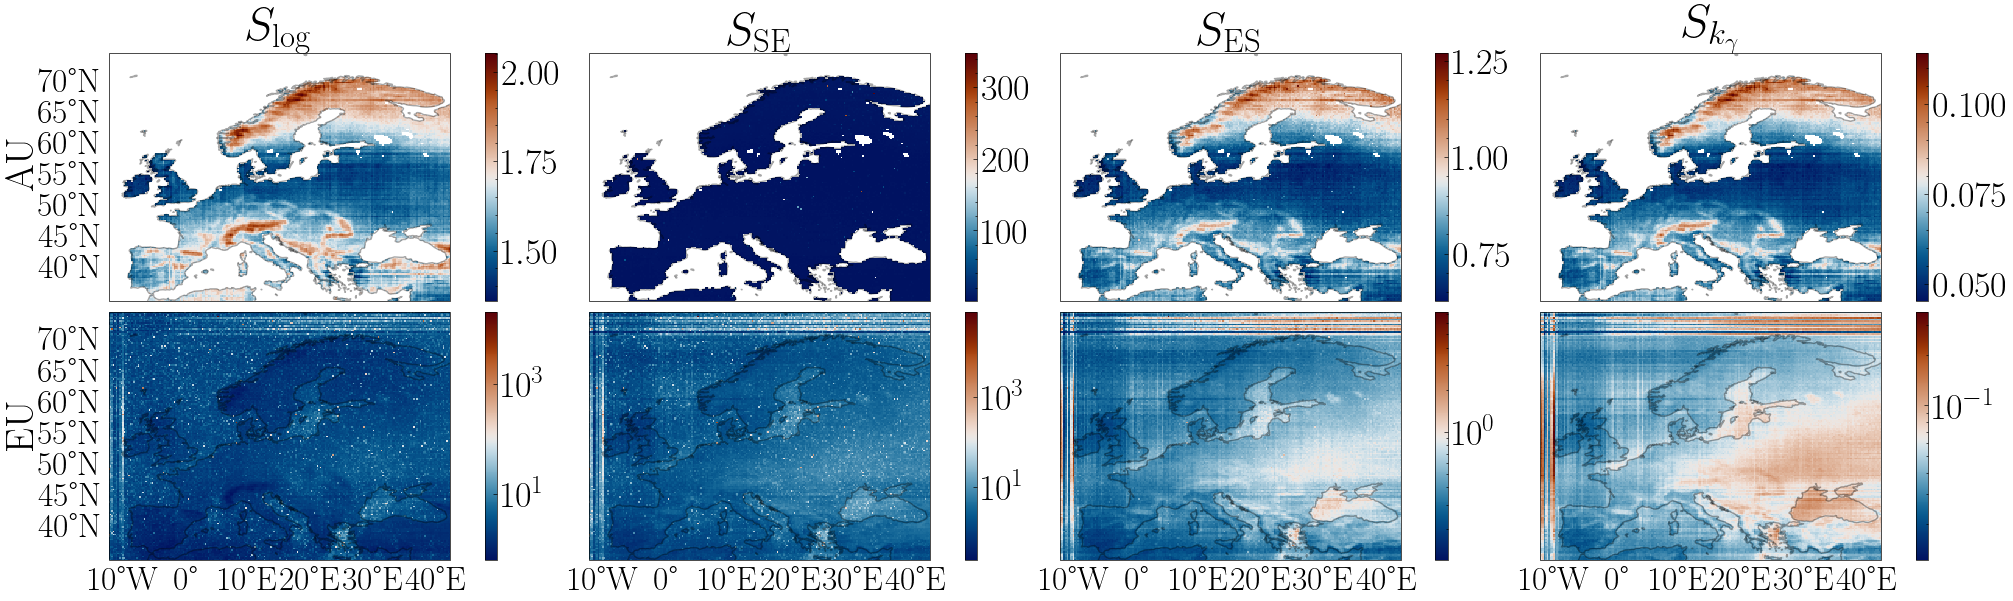

In [54]:
fig, axs = plt.subplots(2, len(measures), figsize=(20, 6), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, layout = "constrained")
for s,measure in enumerate(measures):
    uq_measure = GaussianUQMeasure(torch.tensor(results), gamma = 5)
    au, eu, _ = uq_measure.get_uncertainties(measure = measure)
    au = au.mean(dim = 0)
    eu = eu.mean(dim = 0)
    au = np.where(land_sea_mask <= 0.5, np.nan, au)

    # Plot
    im1 = axs[0,s].pcolormesh(lon, lat, au, shading = "nearest", rasterized = True)
    cb = plt.colorbar(im1, ax=axs[0,s])
    cb.ax.tick_params(labelsize = labelsize)

    im2 = axs[1,s].pcolormesh(lon, lat, eu,rasterized = True, norm = LogNorm())
    cb2 = plt.colorbar(im2, ax=axs[1,s])
    cb2.ax.tick_params(labelsize = labelsize)

    axs[0,s].set_title(names[s], fontsize = titlesize)

for ax in axs.ravel():
    ax.set_extent([lon[0]-360, lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, alpha = 0.35)

for i in range(4):
    gl = axs[1,i].gridlines(draw_labels={"bottom":"x"}, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size':ticksize}

for i in range(2):
    gl = axs[i,0].gridlines(draw_labels={"left":"y"}, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.ylabel_style = {'size':ticksize}

axs[0,0].text(-0.2, 0.55, 'AU', va='bottom', ha='center',
              rotation='vertical', rotation_mode='anchor',
              transform=axs[0,0].transAxes, fontsize = axissize)
axs[1,0].text(-0.2, 0.55, 'EU', va='bottom', ha='center',
     rotation='vertical', rotation_mode='anchor',
    transform=axs[1,0].transAxes, fontsize = axissize)

plt.savefig(f"../../plots/der_{coeff}_uncertainty.pdf", bbox_inches = "tight")